# Learning a Formula of Interpretability to Learn Interpreable Formulas
This notebook loads the survey answers, generates a regression datasets, and learns a linear model out of it.

We begin with some imports and setup.

In [139]:
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import math
import seaborn as sns
from sympy import sympify, latex, nan
import re

matplotlib.rcParams.update({'font.size': 14})

Next we load the answers and related data

In [143]:
results = pd.read_csv("results_335.csv", sep='\t')
# There is one answer for which no background information was recorded. We discard it.
results = results[results['info_freq']!='undefined']
sim1000 = pd.read_csv("sim1000-copy", sep='\t').drop(columns=['Unnamed: 0'])
dec1000 = pd.read_csv("dec1000-copy", sep='\t').drop(columns=['Unnamed: 0'])

# Information on user expertise
We now display information on user expertise.

In [6]:
info = {}
for user in results['hash'].unique():
    row = results[results['hash']==user]
    info[user] = [row.info_freq.unique()[0], row.info_long.unique()[0], row.info_complex.unique()[0], row.info_deal_complex.unique()[0]]

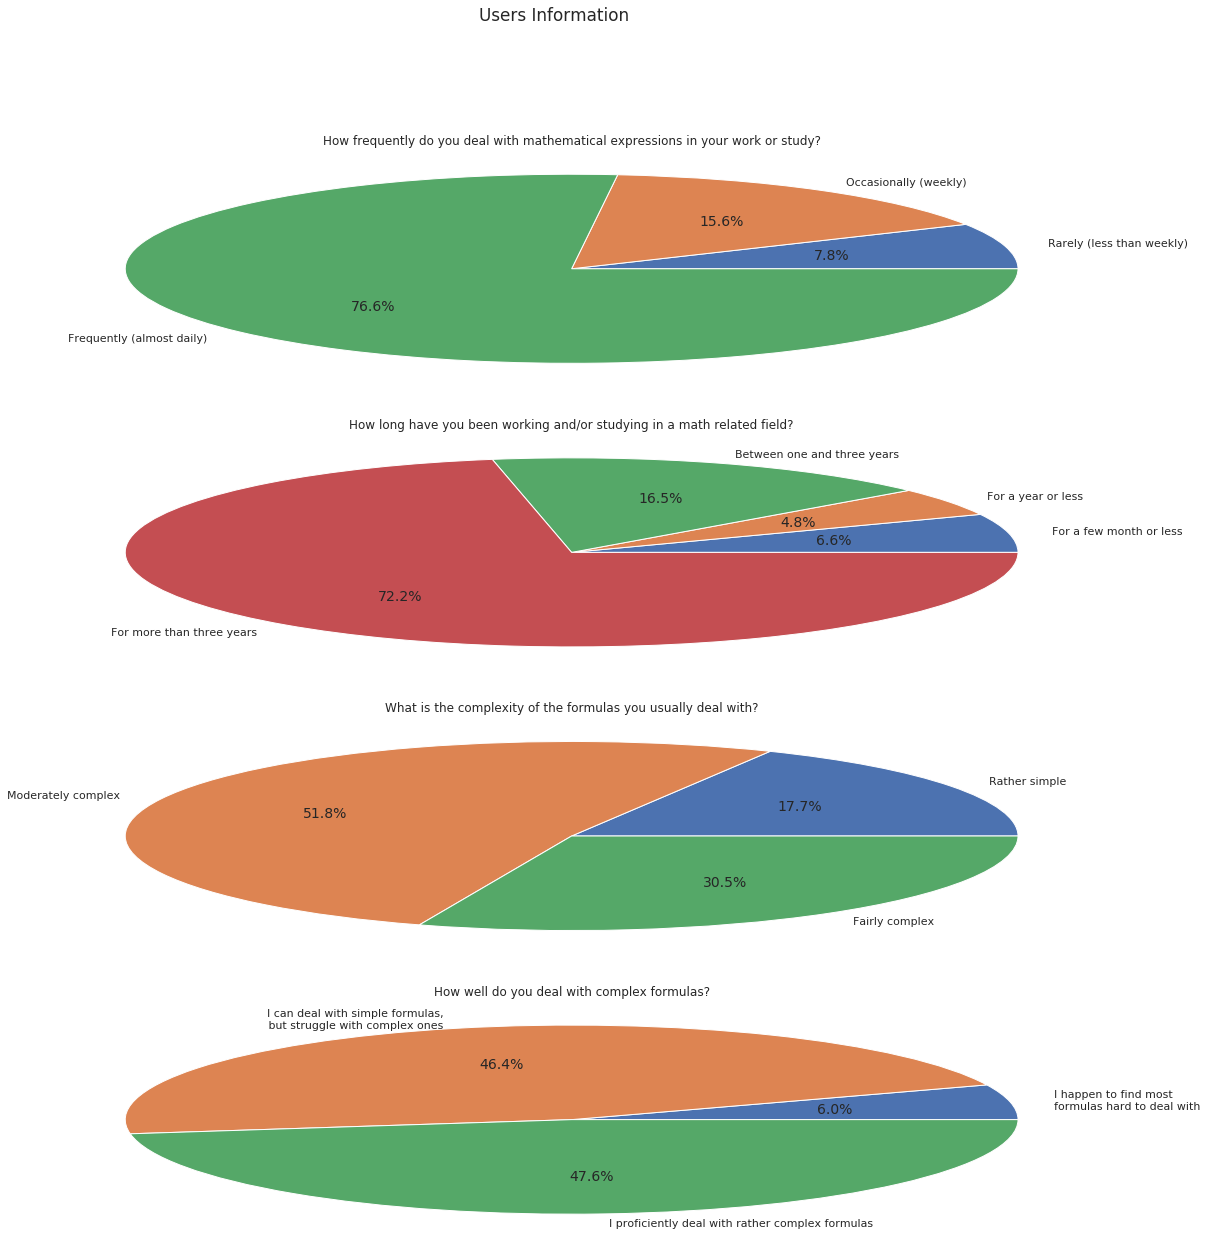

In [145]:
fig = plt.figure(figsize=(20,20))
fig.suptitle('Users Information')
fig.patch.set_facecolor('xkcd:white')

freq = np.zeros(3)
for user in info:
    if int(info[user][0]) == 1:
        freq[0] += 1
    elif int(info[user][0]) == 2:
        freq[1] += 1
    else:
        freq[2] += 1
        
labels = ['Rarely (less than weekly)', 'Occasionally (weekly)', 'Frequently (almost daily)']
ax1 = plt.subplot2grid((4,1),(0,0))
plt.pie(freq, labels=labels, autopct='%1.1f%%')
plt.title('How frequently do you deal with mathematical expressions in your work or study?')
    

long = np.zeros(4)
for user in info:
    if int(info[user][1]) == 1:
        long[0] += 1
    elif int(info[user][1]) == 2:
        long[1] += 1
    elif int(info[user][1]) == 3:
        long[2] += 1
    else:
        long[3] += 1

labels = ['For a few month or less', 'For a year or less','Between one and three years', 'For more than three years']
ax1 = plt.subplot2grid((4,1),(1,0))
plt.pie(long, labels=labels, autopct='%1.1f%%')
plt.title('How long have you been working and/or studying in a math related field?') 

complexity = np.zeros(3)
for user in info:
    if int(info[user][2]) == 1:
        complexity[0] += 1
    elif int(info[user][2]) == 2:
        complexity[1] += 1
    else:
        complexity[2] += 1

labels = ['Rather simple', 'Moderately complex', 'Fairly complex']
ax1 = plt.subplot2grid((4,1),(2,0))
plt.pie(complexity, labels=labels, autopct='%1.1f%%')
plt.title('What is the complexity of the formulas you usually deal with?')

dealing = np.zeros(3)
for user in info:
    if int(info[user][3]) == 1:
        dealing[0] += 1
    elif int(info[user][3]) == 2:
        dealing[1] += 1
    else:
        dealing[2] += 1

labels = ['I happen to find most \nformulas hard to deal with','I can deal with simple formulas,\n but struggle with complex ones','I proficiently deal with rather complex formulas']
ax1 = plt.subplot2grid((4,1),(3,0))
plt.pie(dealing, labels=labels, autopct='%1.1f%%')
plt.title('How well do you deal with complex formulas?')
plt.show()

# Features Extraction
We now drop unnecessary info, and extract salient data on simulatability and decomposability.

In [8]:
questions = results.drop(columns = ['hash', 'info_freq', 'info_long', 'info_complex', 'info_deal_complex'])

Formula feature exctraction methods:

In [10]:
def get_formula(row):
    """ Retrieves the formula corresponding to the question by means of its id """
    expr = sim1000[sim1000['id'] == row.id].expr.tolist()[0]
    expr = sympify(expr)
    return expr

def count_vars(formula):
    """ Counts the number of variables in the formula, counting repetitions """
    n_vars = str(formula).count('x')
    return n_vars
    
def count_dim(formula):
    """ Counts the number of different variables in the formula """
    n_dim = sum([sim in str(formula) for sim in ['x_1','x_2', 'x_3', 'x_4']])
    if n_dim > 0:
        return n_dim
    else:
        return 1
    
def count_consts(expr, consts = None):
    """ Counts the number of constants in the formula """
    if consts is None:
        consts = 0
    if expr.is_number:
        if expr != -1  and expr != 0.5:
            consts +=1
        return consts
    else:
        for arg in expr.args:
            consts = count_consts(arg, consts)
        return consts

def count_ops(formula):
    """ Counts the number of operations in the formula """
    formula = str(formula).replace('**','^')
    ops = 0
    for sim in  ['+', '-', '*', '/', '^', 'sin', 'cos']:
        ops += formula.count(sim)
    return ops

def compute_depth(expr, depth = None):
    """ Computes the depth of the simpy tree representation of the formula"""
    if depth == None:
        depth = 0
    if expr.args == ():
        return depth
    else:
        depth += 1
        depth = max([compute_depth(arg, depth) for arg in expr.args])
        return depth
    
def count_na_ops(expr):
    """ Counts the number of non-arithmetic operations (^,sqrt,sin,cos) in the formula """
    formula = str(expr).replace('**','^')
    ops = 0
    for sim in  ['^', 'sin', 'cos']:
        ops += formula.count(sim)
    return ops

def count_na_comp(expr, count=None):
    """ Counts the maximum number of non-arithmetic chained operations in the formula, e.g. for log(sin(cos(x)) 
    the function returns 3 """
    if count == None:
        count = 0
    if (expr.is_Pow and expr.args[1]!=-1) or str(type(expr)) == 'cos' or str(type(expr)) == 'sin':
        count += 1
        count_args = []
        for arg in expr.args:
            count_args.append(count_na_comp(arg, count))
        count = max(count_args)
        return count
    else:
        if expr.args:
            count_args = []
            for arg in expr.args:
                count_args.append(count_na_comp(arg, count))
            count = max(count_args)
        return count
    
def count_nodes(expr, n_nodes = None):
    """ Counts the number of nodes in the simpy tree representation of the formula """
    if n_nodes is None:
        n_nodes = 1
    if len(expr.args)>0:
        n_nodes += len(expr.args)
        # a/x is read as a*(1/x)
        if expr.is_Mul and any([arg.is_Pow for arg in expr.args]):
            for arg in expr.args:
                if arg.is_Pow and arg.args[1] == -1:
                    n_nodes -= 2
        # -x is read as -1*x
        if expr.is_Mul and expr.args[0] == -1:
            n_nodes -= 1
        for arg in expr.args:
            n_nodes = count_nodes(arg, n_nodes)
    return n_nodes

def count_nodes_by_string(expr):
    """ Counts the number of nodes in the string representation of the formula """
    # n_nodes = count_ops(expr)
    expr = str(expr).replace('**', '^')
    n_nodes = len(re.findall(r'( \+ )|( - )|(\*)| / |\^|sin|cos|exp|log', expr))
    n_nodes += len(re.findall(r'x(?!p)', expr))
    n_nodes += len(re.findall(r'\d+(\.\d+)', expr))
    n_nodes += len(re.findall(r'-(?=x)', expr))
    return n_nodes

In the following we perform the features extraction.
Please, note that we use the `count_nodes_by_string` function nodes count.

In [ ]:
def extract_features(part):
    """
    Extract the features of each formula and stores them in a new dataframe.
    Features extracted:
    - formula
    - n_vars = number of variables (counts repetitions)
    - n_dim = number of dimensions
    - n_const = the number of constants in the formula
    - n_ops = number of operations
    - depth = depth of the tree (in sympy representation)
    - na_ops = number of non arithmetic operations
    - na_comp = maximum number of comosition of non arithmetic operations 
    - n_nodes = the number of nodes in a tree representing the formula
    """
    
    df = pd.DataFrame(columns = ['exprs','n_vars', 'n_dim','n_const', 'depth', 'na_ops','na_comp', 'n_nodes', 
                                 'correct','confidence'])
    
    data = questions[questions.part == part]

    for i in range(0,len(data)):
        row = data.iloc[i]
        expr = get_formula(row)
   
        
        new_row = {}
        new_row['exprs'] = expr
        new_row['n_vars'] = count_vars(expr)
        new_row['n_dim'] = count_dim(expr)
        new_row['n_const'] = count_consts(expr)
        new_row['n_ops'] = count_ops(expr)
        new_row['depth'] = compute_depth(expr)
        new_row['na_ops'] = count_na_ops(expr)
        new_row['na_comp'] = count_na_comp(expr)
        new_row['n_nodes'] = count_nodes_by_string(expr)
        
        new_row['correct'] = str(row.answer == row.correct)
        new_row['confidence'] = row.confidence
        
        df = df.append(new_row, ignore_index = True)
    
    return df

## Simulatability

In this section we analyze and report the results about the simulatability questions.
We extract the features for these questions and we plot the results of the survey.

In [156]:
sim = extract_features('sim')
sim

,exprs,n_vars,n_dim,n_const,depth,na_ops,na_comp,n_nodes,correct,confidence,n_ops
0,sin(x + 3.14) + 7,1,1,2,3,1,1,5,True,3,3.0
1,x_1 + sin(x_3 + 1.57) + cos(x_2 - 1.57) + 7,3,3,3,3,2,1,12,True,4,7.0
2,-x_1**x_4 - x_2*x_3 - x_4 + 7 + 8/x_2,6,4,2,3,1,1,13,True,4,8.0
3,(x**0.5 + 2)**0.5,1,1,1,3,2,2,6,True,2,3.0
4,sin(3.14*x_1)**0.5/cos(x_2 + 1.57),2,2,2,4,3,2,10,False,3,6.0
...,...,...,...,...,...,...,...,...,...,...,...
1331,x_1 + 2*x_2 + 5,2,2,2,2,0,0,5,True,4,3.0
1332,sin(x + 3.14)**0.5,1,1,1,3,2,2,6,False,3,3.0
1333,(x_1 + x_1**x_2 + sin(3.14*x_1))**0.5,4,2,1,4,3,2,12,True,4,6.0
1334,5*x + 6,1,1,2,2,0,0,3,True,4,2.0


A function to plot correct answer ratios over single variables. 

In [ ]:
def plot_single_var(data, part):
    features = ['n_vars', 'na_ops', 'na_comp', 'depth', 'confidence']
    n_feat = len(features)
    
    plt.figure(figsize = (10,15))
    if part == 'sim':
        plt.suptitle('Simulatability questions', fontsize = 15, y = -0.01)
    elif part == 'dec':
        plt.suptitle('Decomposability questions', fontsize = 15, y = -0.01)
    for i, label in enumerate(features):
        values = sorted(data[label].unique())
        df = pd.DataFrame(columns = [label, 'norm_correct', 'one'])
        k = 0
        for val in values:
            tot = len(data[data[label]==val])
            correct = len(data.loc[(data[label] == val) & (data['correct']==str(True))])
            df.loc[k] = [val, correct/tot, 1]
            k +=1

        ax = plt.subplot(n_feat, 1, i+1)
        sns.set(style="whitegrid")
        sns.set_color_codes("pastel")
        sns.barplot(x=label, y='one', data=df, label="Total", color="b")
        sns.set_color_codes("muted")
        sns.barplot(x=label, y='norm_correct', data=df, label="Normalized correct", color="b")
        sns.despine(left=True, bottom=True)

    plt.tight_layout()

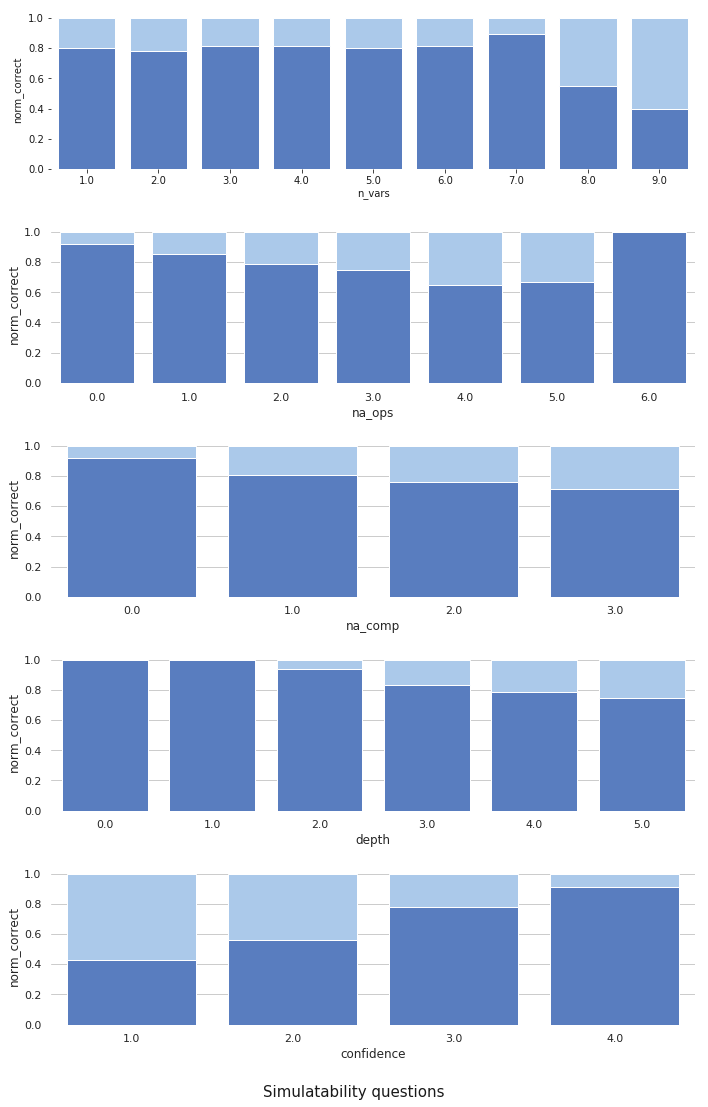

In [13]:
plot_single_var(sim, 'sim')

Note that while most plots are reasonable, we obtain a conter-intuitive result for `na_ops=6`. This is a fluke due to only 3 answers being given:

In [158]:
sim[sim['na_ops']==6]

,exprs,n_vars,n_dim,n_const,depth,na_ops,na_comp,n_nodes,correct,confidence,n_ops
718,5*6.28**(5*sin(x_2))*x_1*x_3*x_4 + x_2**5 + x_...,9,4,9,5,6,2,31,True,3,20.0
829,5*6.28**(5*sin(x_2))*x_1*x_3*x_4 + x_2**5 + x_...,9,4,9,5,6,2,31,True,3,20.0
1176,4*x_1/x_3 - x_2**0.5*cos(x_4 + 1.57) + sin(x_1...,7,4,6,5,6,2,30,True,2,18.0


## Decomposability

Now we calculate the features for the decomposability part

In [14]:
dec = extract_features('dec')

# Binning formulas by features

We condense the survey answers into a regression dataset.
We begin with replacing each question with a set of feature values that represents the formula contained in the question.
We btain multiple identical sets of feature values with different outcomes in terms of correctness and confidence.
We merge equal sets of feature values into a sin-gle sample, taking the ratio of correct answers and the mean user confidence.

In [15]:
correct_label_mapping = {'True': 1, 'False':0}

def compute_interpr(corr, conf):
    # map conf to 0---1
    conf_norm = (conf - 1) / (4 - 1)
    interpr = np.multiply(corr, conf_norm)
    
    return interpr

def group_by_feature(data, features = ['n_vars', 'na_ops', 'na_comp']):
    total = data.groupby(features)["exprs"].count().reset_index()
    
    nan_entries = np.empty(len(total))
    nan_entries[:] = np.nan
    
    total.at[:,'confidence'] = pd.Series(nan_entries)
    total.at[:,'correct'] = pd.Series(nan_entries)
    total.at[:,'interpr'] = pd.Series(nan_entries)
    k = 0
    for i in range(len(total)):
        query = ''
        for label in features:
            query = query + label + '==' 
            query = query +  str(total.iloc[i][label]) + " & "
        query = "".join(query.rsplit('&', 1))
        result = data.query(query) 
        result.replace({'correct': correct_label_mapping}, inplace=True)
        
        interpr = compute_interpr( result['correct'].to_numpy(), result['confidence'].to_numpy() )
        
        mean_confidence = result['confidence'].mean()
        mean_correct = result['correct'].mean()
        total.loc[k, 'confidence'] = np.round(mean_confidence, 2)
        total.loc[k, 'correct'] = np.round(mean_correct,2)
        total.loc[k, 'interpr'] = np.round(np.mean(interpr),2)
        k += 1
    
    return total


In [126]:
features =  ['n_nodes','n_ops','na_ops','na_comp']

sim_dec_grouped = group_by_feature(pd.concat([sim, dec]), features)
sim_dec_grouped_filtered = sim_dec_grouped[sim_dec_grouped['exprs'] >= 10].drop(['exprs'], axis=1).reset_index(drop=True)

print( sim_dec_grouped_filtered['interpr'].min(), sim_dec_grouped_filtered['interpr'].max() )

sim_dec_grouped_filtered

/export/scratch2/home/virgolin/.local/lib/python3.6/site-packages/pandas/core/generic.py:6702: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regex=regex,


0.31 0.92


,n_nodes,n_ops,na_ops,na_comp,confidence,correct,interpr
0,2,1,0,0,3.80,0.95,0.88
1,3,2,0,0,3.52,0.80,0.75
2,4,2,0,0,3.55,0.91,0.85
3,4,2,1,1,3.48,0.86,0.73
4,4,3,1,1,3.40,0.89,0.77
...,...,...,...,...,...,...,...
68,19,11,3,2,3.39,0.78,0.72
69,19,12,2,1,3.33,0.67,0.53
70,20,12,4,1,3.21,0.79,0.71
71,20,12,4,2,2.64,0.45,0.36


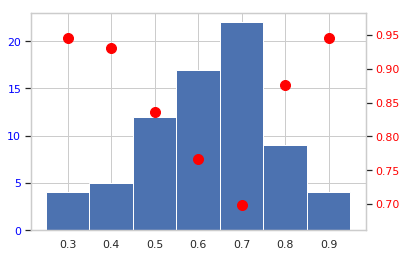

phi freq weights
0.3 0.055 0.945
0.4 0.068 0.932
0.5 0.164 0.836
0.6 0.233 0.767
0.7 0.301 0.699
0.8 0.123 0.877
0.9 0.055 0.945



In [134]:
# prepare data for training
X = sim_dec_grouped_filtered.drop(['correct','confidence','interpr'], axis=1).to_numpy()
y = sim_dec_grouped_filtered['interpr'].to_numpy()


#let's compute weights based on occurrency
y_classes = (y*20).astype(int) / 2
y_classes = y_classes / 10

bins = [.25,.35,.45,.55,.65,.75,.85,.95]

freq, classes = np.histogram(y_classes, bins=bins)
classes = classes[:-1].copy()
freq = freq / np.sum(freq)

y_weights = np.ones(len(y))
for i in range(len(y)):
    idx = (np.abs(y[i] - classes)).argmin()
    y_weights[i] = 1 - freq[idx]
    

# show weighting    
hist_labels = (np.array(bins)+0.05)[:-1] 
fig, ax = plt.subplots( 1, 1, figsize=(6,4) )
ax.hist(y_classes, bins=np.array(bins))
ax2 = ax.twinx()
ax2.scatter(hist_labels, (1-freq), color='red', s=100)
ax2.grid(False)
ax2.tick_params(axis='y', labelcolor='red')
top_y = np.max(freq) * len(y) + 1
ax.set_ylim(bottom=0,top=top_y)
ax.tick_params(axis='y', labelcolor='blue')

fig.savefig('hist_y.pdf')
plt.show()

# store means and std for later
Xmean = np.mean(X, axis=0)
Xstd = np.std(X, axis=0)
ymean = np.mean(y)
ystd = np.std(y)

d = pd.DataFrame({'phi':np.round(hist_labels,1), 'freq':np.round(freq,3), 'weights':np.round(1-freq,3)})
print(d.to_csv(index=False, sep=' '))

## Learning the model

Here we train the model for interpretability evaluation.
The model is based on linear elastic net.

In [135]:
def LearnInterpretabilityModel(n_jobs=1):
    
    from sklearn.linear_model import SGDRegressor as SGDR
    from sklearn.model_selection import cross_validate, LeaveOneOut, GridSearchCV, KFold
    from sklearn.preprocessing import scale, minmax_scale, PolynomialFeatures
    
    Xs = scale(X)
    ys = scale(y)
    
    lr_hyperparams = { 
                       'alpha' : [0.01, 0.25, 0.5, 0.75, 1.0], 'l1_ratio' : [0.01, 0.25, 0.5, 0.75, 1.0] 
                     }

    estimator = SGDR(penalty='elasticnet', fit_intercept=False)
    hyperparams = lr_hyperparams
    
    train_mses = []
    test_mses = []
    training_variances = []
    elitist_infos = []
    best_hyperparams = []
    cval = LeaveOneOut()  # KFold(n_splits=10) #LeaveOneOut() 
    for split in cval.split(y):
        
        X_train = Xs[split[0]]
        y_train = ys[split[0]]
        X_test = Xs[split[1]]
        y_test = ys[split[1]]
        
        sw_train = y_weights[split[0]]
        sw_test = y_weights[split[1]]
        
        w_average = np.average(y_train, weights=sw_train)
        w_variance = np.average((y_train - w_average)**2, weights=sw_train)
        training_variances.append(w_variance)
            
        gs = GridSearchCV(estimator, hyperparams, n_jobs=n_jobs, scoring='neg_mean_squared_error', cv=5, refit=True, return_train_score=True, iid=False)
        gs_result = gs.fit(X_train, y_train, sample_weight=sw_train)
                
        train_mse = np.mean(np.square (np.multiply(sw_train, y_train - gs_result.best_estimator_.predict(X_train))) ) 
        test_mse = np.mean(np.square(np.multiply(sw_train, y_test - gs_result.best_estimator_.predict(X_test) )) )

        train_mses.append(train_mse)
        test_mses.append(test_mse)
        el_info = gs_result.best_estimator_.coef_.tolist()
        el_info.append( gs_result.best_estimator_.intercept_[0])
        elitist_infos.append( el_info )

        best_hyperparams.append( gs_result.best_params_ )
        
    
    return_package = (train_mses, test_mses, training_variances, elitist_infos, best_hyperparams)
    return return_package

Now we prepare the leave-one outcross-validation.
We use the R2 scores for assessing performance on both traing and testing set.

In [ ]:
np.random.seed(42) # for reproducibility
result = LearnInterpretabilityModel(n_jobs=1)

# print results
train_mses = result[0]
test_mses = result[1]
training_variances = result[2]
print('MSE:',np.round(np.mean(train_mses)*ystd, 3), np.round(np.mean(test_mses)*ystd, 3))
print('R^2:',np.round(1 - np.mean(train_mses)/np.mean(training_variances), 3), np.round(1 - np.mean(test_mses)/np.mean(training_variances), 3) )
   
# show mean coefficients learned
n_feats = len(result[3][0])
models = np.array(result[3]).reshape((-1,n_feats))
mean_coeffs = np.mean(models, axis=0)
std_coeffs = np.std(models, axis=0)
print('\nfeatures','\t\t',sim_dec_grouped_filtered.columns.tolist()[:n_feats-1]+['intercept'])
print('coeff.normalized','\t',mean_coeffs)

mean_coeffs_rescaled = mean_coeffs[:-1] / Xstd
new_intercept = np.sum( -1 * np.multiply(mean_coeffs[:-1], Xmean/Xstd) )
print('coeff.scaled back','\t',np.array(np.round(mean_coeffs_rescaled * ystd, 10).tolist() + [ np.round(new_intercept * ystd + ymean, 10)]))

In [ ]:
n_feats = len(result[3][0])

models = np.array(result[3]).reshape((-1,n_feats))
models = models[:,0:n_feats-1].copy()
print(models.shape)

mean_coeffs = np.mean(models, axis=0)
std_coeffs = np.std(models, axis=0)

data = []
for i in range(models.shape[1]):
    coeff = models[:,i] 
    data.append(coeff)

fig, ax = plt.subplots(figsize=(6,3))
ax.boxplot(data)

ax.hlines(0,0,len(features)+1)


font_size = 14
ax.tick_params(axis='x', labelsize=font_size)
ax.tick_params(axis='y', labelsize=font_size)

ax.set_xticklabels(features)

fig.tight_layout()

plt.show()

fig.savefig('selected_feats_coeffs.pdf')


In [ ]:
n_feats = len(result[3][0])

models = np.array(result[3]).reshape((-1,n_feats))
models = models[:,0:n_feats-1].copy()
print(models.shape)

mean_coeffs = np.mean(models, axis=0)
std_coeffs = np.std(models, axis=0)

data = []
for i in range(models.shape[1]):
    coeff = models[:,i] / Xstd[i] * ystd * 100
    print(np.mean(coeff))
    data.append(coeff)

fig, ax = plt.subplots(figsize=(6,3))
ax.boxplot(data)

ax.hlines(0,0,len(features)+1)

font_size = 14
ax.tick_params(axis='x', labelsize=font_size)
ax.tick_params(axis='y', labelsize=font_size)

ax.set_xticklabels(features)

ax.grid(color='lightgray')

fig.tight_layout()

plt.show()

fig.savefig('selected_feats_coeffs.pdf')


d = {}
for i, f in enumerate(features):
    d[f] = np.round(data[i],3)
    print(f,np.mean(data[i]))
df = pd.DataFrame(d)
print(df.to_csv(index=False,sep=' '))

MSE: 0.075 0.069
R^2: 0.506 0.545

features 		 ['n_nodes', 'n_ops', 'na_ops', 'na_comp', 'intercept']
coeff.normalized 	 [-0.06704887 -0.1065361  -0.23471872 -0.17230369  0.        ]
coeff.scaled back 	 [-0.00195041 -0.00502375 -0.03351907 -0.04472121  0.79074077]


(73, 4)


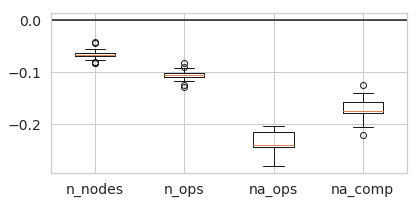

In [137]:
n_feats = len(result[3][0])

models = np.array(result[3]).reshape((-1,n_feats))
models = models[:,0:n_feats-1].copy()
print(models.shape)

mean_coeffs = np.mean(models, axis=0)
std_coeffs = np.std(models, axis=0)

data = []
for i in range(models.shape[1]):
    coeff = models[:,i] 
    data.append(coeff)

fig, ax = plt.subplots(figsize=(6,3))
ax.boxplot(data)

ax.hlines(0,0,len(features)+1)


font_size = 14
ax.tick_params(axis='x', labelsize=font_size)
ax.tick_params(axis='y', labelsize=font_size)

ax.set_xticklabels(features)

fig.tight_layout()

plt.show()

fig.savefig('selected_feats_coeffs.pdf')


(73, 4)
-0.19504057410784603
-0.5023746003484102
-3.3519068735998845
-4.472121048598179


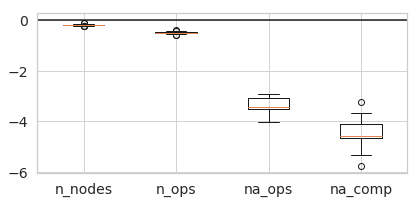

n_nodes -0.19504057410784603
n_ops -0.5023746003484102
na_ops -3.3519068735998845
na_comp -4.472121048598179
n_nodes n_ops na_ops na_comp
-0.17 -0.431 -3.032 -3.677
-0.204 -0.527 -3.519 -4.72
-0.181 -0.441 -2.981 -3.767
-0.182 -0.462 -3.077 -4.044
-0.189 -0.467 -3.048 -4.086
-0.187 -0.463 -3.04 -3.869
-0.197 -0.517 -3.39 -4.691
-0.193 -0.514 -3.459 -4.62
-0.199 -0.511 -3.455 -4.627
-0.196 -0.52 -3.5 -4.477
-0.194 -0.489 -3.178 -4.138
-0.241 -0.59 -2.999 -3.257
-0.208 -0.483 -3.153 -4.408
-0.203 -0.516 -3.532 -4.617
-0.202 -0.486 -3.052 -4.004
-0.176 -0.505 -3.528 -4.67
-0.197 -0.529 -3.432 -4.427
-0.2 -0.457 -3.316 -4.583
-0.193 -0.505 -3.443 -4.629
-0.2 -0.501 -3.04 -4.175
-0.191 -0.525 -3.541 -4.361
-0.183 -0.491 -2.917 -4.126
-0.204 -0.508 -3.323 -4.66
-0.202 -0.489 -3.114 -4.088
-0.192 -0.53 -3.405 -4.704
-0.224 -0.491 -2.937 -4.214
-0.194 -0.478 -3.004 -4.064
-0.193 -0.471 -3.042 -4.118
-0.179 -0.474 -3.132 -4.0
-0.215 -0.503 -2.925 -3.836
-0.195 -0.533 -3.396 -4.65
-0.195 -0.522 

In [138]:
n_feats = len(result[3][0])

models = np.array(result[3]).reshape((-1,n_feats))
models = models[:,0:n_feats-1].copy()
print(models.shape)

mean_coeffs = np.mean(models, axis=0)
std_coeffs = np.std(models, axis=0)

data = []
for i in range(models.shape[1]):
    coeff = models[:,i] / Xstd[i] * ystd * 100
    print(np.mean(coeff))
    data.append(coeff)

fig, ax = plt.subplots(figsize=(6,3))
ax.boxplot(data)

ax.hlines(0,0,len(features)+1)

font_size = 14
ax.tick_params(axis='x', labelsize=font_size)
ax.tick_params(axis='y', labelsize=font_size)

ax.set_xticklabels(features)

ax.grid(color='lightgray')

fig.tight_layout()

plt.show()

fig.savefig('selected_feats_coeffs.pdf')


d = {}
for i, f in enumerate(features):
    d[f] = np.round(data[i],3)
    print(f,np.mean(data[i]))
df = pd.DataFrame(d)
print(df.to_csv(index=False,sep=' '))